# Continuous Action Control with Policy Gradients

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [2]:
# Function to render in notebook
def render_frame(env):
    frame = env.render()  # Returns the rendered frame as an RGB array
    plt.imshow(frame)
    plt.axis('off')  # Hide axis for better visualization
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

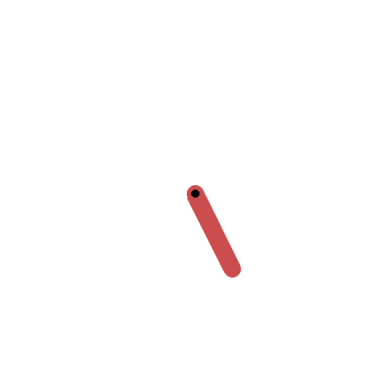

In [3]:
# Initialize the environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

render_frame(env)

### Goal 
- Apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

### Observation Space
- The observation is a ndarray with shape (3,) of continuous variables representing the x-y coordinates of the pendulum’s free end and its angular velocity.
    - x = cos(angle) [-1, 1]
    - y = sin(angle) [-1, 1]
    - z = theta, angular velocity [-8, 8]

### Action
- The torque applied to the end of the pendulum [-1, 1]

### Reward
- r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)
    - max is 0 when the pendulum is upright and no torque is applied

### End of episode
- After 200 timesteps

### Random Policy

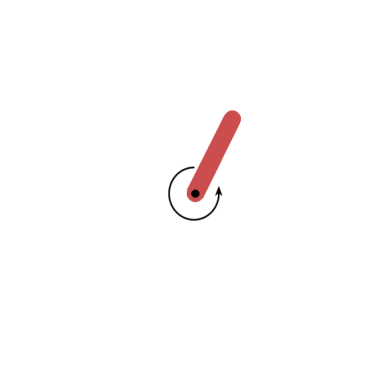

In [4]:
# visualize random policy

env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

for _ in range(100):
    state, reward, done, _, info = env.step(env.action_space.sample())
    render_frame(env)

env.close()

In [5]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32), Box(-2.0, 2.0, (1,), float32))

## Policy Network for Continuous Actions

![policy_network](img/policy_network.png)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(obs_size, 32)
        self.mu = nn.Linear(32, num_actions)
        self.std = nn.Linear(32, num_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        mu = torch.tanh(self.mu(x)) # tanh projects mu into -1, 1
        std = F.softplus(self.std(x)) + 1e-4 # small constant for numerical stability
        
        pi = Normal(mu, std)
        action = pi.sample()
        action = torch.clamp(action, -1., 1.) # ensure after sampling action is in -1, 1
        return action, pi


In [7]:
p_network = PolicyNetwork(obs_size=3, num_actions=1)
action, pi = p_network(torch.tensor(state))
action, pi

(tensor([-0.2497]),
 Normal(loc: tensor([-0.0990], grad_fn=<TanhBackward0>), scale: tensor([0.5493], grad_fn=<AddBackward0>)))

In [8]:
action = pi.sample()
prob = pi.log_prob(action)
print(action, prob)

tensor([-0.0902]) tensor([-0.3200], grad_fn=<SubBackward0>)


## Reinforce

![reinforce](img/reinforce.png)

Fun Fact: REINFORCE is an acronym for “ ‘RE’ward ‘I’ncrement ‘N’on-negative ‘F’actor times ‘O’ffset ‘R’einforcement times ‘C’haracteristic ‘E’ligibility

In [9]:
def reinforce(env, gamma=0.99, learning_rate=0.001, num_episodes=1000, training_episodes=4):
    
    obs_size = env.observation_space.shape[0]
    p_network = PolicyNetwork(obs_size=obs_size, num_actions=1)
    optimizer = torch.optim.Adam(p_network.parameters(), lr=learning_rate)

    episode_returns = []
    for episode in range(1, num_episodes + 1):
        
        rewards = [] # (n_episodes, timesteps)
        states  = [] # (n_episodes*timesteps)
        actions = [] # (n_episodes*timesteps)

        for n in range(training_episodes):
            
            # Collect episode
            state, info = env.reset()
            done = False
            ep_rewards = []
            cum_reward = 0
            
            while not done:

                with torch.no_grad():

                    state_tensor = torch.tensor(state)
                    action, pi = p_network(state_tensor)
                    states.append(state_tensor)
                    actions.append(action)
    
                    action = action*env.action_space.high[0] # project action into original action space (i.e., -2, 2)
                    state, reward, done, truncated, _ = env.step(action.numpy())
                    done = done or truncated
                    cum_reward += reward
                    ep_rewards.append(reward)

            rewards.append(ep_rewards)
            episode_returns.append(cum_reward)

        # Compute discounted returns
        returns = []
        for i in range(training_episodes):
            R = 0
            ep_returns = []
            for r in reversed(rewards[i]):
                R = r + gamma * R
                ep_returns.insert(0, R)
            returns.extend(ep_returns)
            
        returns = torch.tensor(returns)

        # Compute loss and optimize
        _, pi = p_network(torch.stack(states))
        log_probs = pi.log_prob(torch.stack(actions)).squeeze()
        loss = torch.mean(-log_probs * returns)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log
        if episode % 100 == 0:
            print(f'Episode {episode}, loss: {loss} returns: {np.mean(episode_returns[-100:])}')

    return p_network, episode_returns

In [10]:
%%time
p_network, returns = reinforce(env, num_episodes=1000, training_episodes=4)

Episode 100, loss: -614.9189237027198 returns: -1257.735809674458
Episode 200, loss: -793.872301501516 returns: -1180.2767136861692
Episode 300, loss: -1027.388189672054 returns: -1216.093477099968
Episode 400, loss: -1142.7788665434396 returns: -1201.8974870866439
Episode 500, loss: -1263.6239075502244 returns: -1184.9533817735164
Episode 600, loss: -1368.477270972343 returns: -1212.1110200360145
Episode 700, loss: -1376.3632435222833 returns: -1193.990718124976
Episode 800, loss: -1485.0569945089012 returns: -1227.8542819599786
Episode 900, loss: -1445.4119300688749 returns: -1236.8994319462765
Episode 1000, loss: -1322.3671109575414 returns: -1148.2401307546063
CPU times: user 1min 14s, sys: 186 ms, total: 1min 15s
Wall time: 1min 15s


Text(0, 0.5, 'Returns')

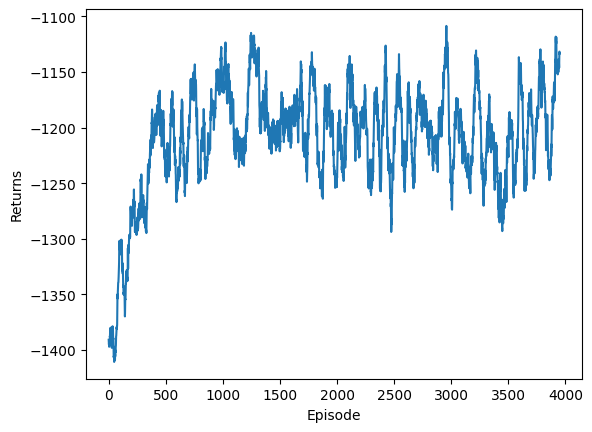

In [12]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(returns))
plt.xlabel('Episode')
plt.ylabel('Returns')

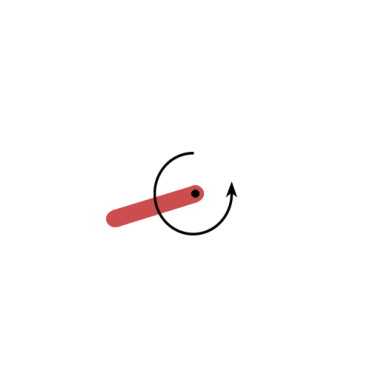

-957.2642217157181


In [14]:
state, info = env.reset()
render_frame(env)
done = False

r = 0
while not done:

    with torch.no_grad():
        action, _ = p_network(torch.tensor(state))
        action = action*env.action_space.high[0]

    state, reward, done, truncated, _ = env.step(action.numpy())
    done = done or truncated
    render_frame(env)
    r += reward

print(r)

**Reinforce is not able to solve this simple task. Notice that the standard PG loss in this environment has very high variance. Moreover, continuous action problems can be singificantly harder for simple baselines.**